# Applying WOfS and its Accuracy Assessment to Africa <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat Collection 2 surface reflectance and shows water detected for selected areas of Africa.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use WOfS derived product to perform accuracy assessment of the product using ground truth dataset.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period 
2. Inspect the WOFL bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to fractional cover dataset 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [5]:
%matplotlib inline

import datacube
from datacube.utils import masking 
import sys
import os
import dask 
import rasterio
import xarray
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard
from rasterio.mask import mask


In [3]:
# #the following packages are essential for classification part using machine learning 
# import pydotplus
# import warnings
# import geopandas as gpd
# from io import StringIO
# from joblib import dump
# from pprint import pprint
# import multiprocessing as mp
# from IPython.display import Image
# from sklearn import tree, model_selection
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# from datacube.utils.dask import start_local_dask
# from datacube.helpers import write_geotiff
# from deafrica_classificationtools import predict_xr, collect_training_data
# from deafrica_plotting import map_shapefile, rgb
# from deafrica_bandindices import calculate_indices
# warnings.filterwarnings("ignore")

### Connect to the datacube

In [6]:
dc = datacube.Datacube(app="Applying_WOfS")

### Analysis parameters

In [12]:
#Site location in Tanzania close to the border with Kenya
#change the location to somewhere in Ghana 
lat, lon =  -6.083 ,35.184
buffer = 0.10

x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2019-01-01', '2019-03-20'),
    'resolution': (-30, 30)
}

output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2', query=query) #use the collection 2 one here that should have 2018


#The following part should change following update for training dataset in order to use ML classification 
path = '../Supplementary_data/Machine_learning_with_ODC/test_training_data.shp' # this part will change with having test training shapefile 
field = 'class'
products =  ['ga_ls8c_wofs_2'] #this can be changed to another one that you want to use as your raster 
time = ('2018')
reduce_func = None #'geomedian'
custom_func = None
band_indices = None #['NDVI'] 
drop = False
zonal_stats = None #'median' 
resolution =  (-30, 30)
align = (15,15)

#automatically detect the number of cpus
ncpus=int(float(sp.getoutput('env | grep CPU')[-3:]))


../Scripts/deafrica_datahandling.py:600: UserWarning: Multiple UTM zones ['epsg:32637', 'epsg:32636'] were returned for this query. Defaulting to the most common zone: epsg:32637
  UserWarning)


### View the selected location

In [13]:
display_map(x=x, y=y)

## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [14]:
# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2", output_crs=output_crs, group_by="solar_day",
                            fuse_func=wofs_fuser, **query)

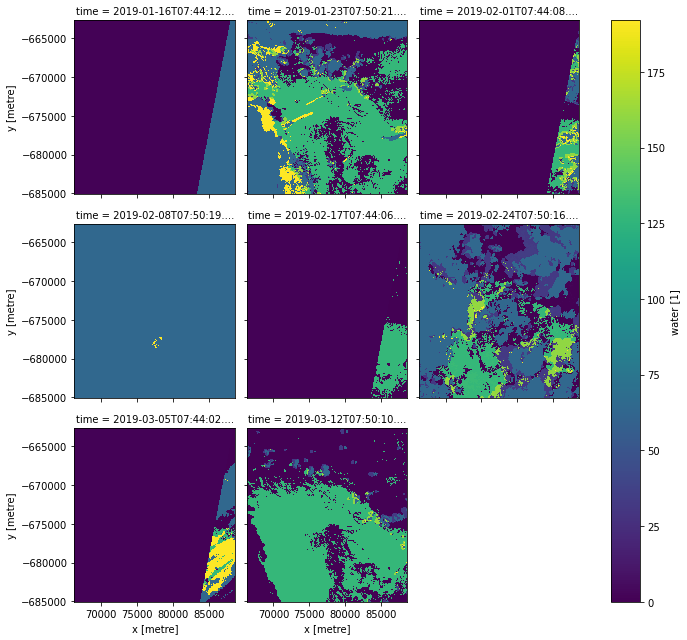

In [15]:
# Plot the loaded WOFLs
wofls.water.plot(col="time", col_wrap=3)
plt.show()

In [17]:
# Select one image of interest (`time=2` selects the third observation)
wofl = wofls.isel(time=1)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [18]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
contiguous,1,"{'0': True, '1': False}",Contiguity
sea,2,"{'0': False, '1': True}",Sea
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


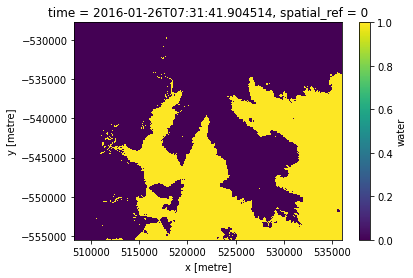

In [19]:
# Show areas flagged as water only (with no other flags set)
(wofl.water == 128).plot.imshow()
plt.show()

We can convert the WOFL bit field into a binary array containing True and False values. This allows us to use the WOFL data as a mask that can be applied to other datasets.
The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above. For more details on how to do masking on WOfS, see the [Applying_WOfS_bit_masking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.


## Extract training data using a shapefile

**Training data** as part of machine learning workflow has a greater impact on the classification than the algorithm used. In order to reduce the high variance in the prediction and improve classification accuracy, large and accurate training data sets are preferable. Capturing `spectral variability` of the class and using satellite imagery from the classification time period rather than relying on basemap, could improve the quality of training dataset. `class imbalance` is another common problem with training data that occurs when one of classes is relatively rare and comprise a smaller proportion of the training set. This normally will result in under-prediction of less abundant classes relative to their true proportion in final classification.  

> **Note**: The training data provided by default is `for demonstration purposes only` and should not be relied upon for real world analysis.  

***

Firstly, let's open our training data and visualize it using the function `map_shapefile`

In [ ]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapfile by plotting it
map_shapefile(input_data, attribute=field)

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations. 

The function `collect_training_data` takes our shapefile containing class labels and extracts traning data from the datacube over the location specified by the input geometries. The function will also pre-process our training data by stacking the arrays into a useful format and removing an `NaN` (not-a-number) values.


> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.  If you set `ncpus > 1`, then this function will be run in parallel across the specified number of processes.


In [ ]:
#generate a datacube query object (The measurement needs to be changed based on the WOfS layer)
query = {
    'time': time,
    'measurements': ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'],
    'resolution': resolution,
    'align' : align,
    'group_by' :'solar_day',
}

In [ ]:
#Collect the training data from the datacube
column_names, model_input = collect_training_data(
                                    gdf=input_data,
                                    products=products,
                                    dc_query=query,
                                    ncpus=ncpus,
                                    custom_func=custom_func,
                                    field=field,
                                    calc_indices=band_indices,
                                    reduce_func=reduce_func,
                                    drop=drop,
                                    zonal_stats=zonal_stats)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [ ]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

## Model Preparation 

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [ ]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below by adding or changing variables in the `classifier_params` below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [ ]:
classifier_params = {'criterion': 'gini',
                     'max_depth' : 10,
                     'splitter' : 'random',
                     'min_samples_split' : 100}

model = tree.DecisionTreeClassifier(**classifier_params, random_state=1)

## Train model 

The model is fitted / trained using the prepared training data. The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. This fitted / trained model can then be used to predict which class new data belongs to.

In [ ]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])
#We can save the model as joblib that allows for importing it into other scripts should we wish to use the same model to classify a different region.
dump(model, 'ml_model.joblib')

## Prediction 

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.

> If you changed any of the parameters in the `Analysis Parameters` section from their default values, then these changes will need to be reflected in the code below. For the prediction section to work, it requires loading the same data as is loaded in the training data. The user needs to update this section manually.

In [ ]:
# Load the data based on query around the user supplied
# lat/long and buffer 
q = {'x': (long-buffer, long+buffer),
     'y': (lat+buffer, lat-buffer)}
query.update(q)
        
#get output crs    
output_crs = mostcommon_crs(dc=dc, product=products, query=query)

#load geomedian data and mask no-data values
data = dc.load(product='ga_ls8c_gm_2_annual', **query)
data = data.where(data!=0, np.nan)

#calcuate band indices
if band_indices is not None:
    data = calculate_indices(data,
                             band_indices, 
                             drop=drop,
                             collection='c2')


In [ ]:
# Predict landcover using the trained model
predicted = predict_xr(model, data, progress=True)

## Plotting 

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - Use the `Evaluate Classifier` steps below to help you improve the model

In [ ]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot classified image
predicted.plot(ax=axes[0], 
               cmap='Blues', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(data, ax=axes[1], percentile_stretch=(0.01, 0.99))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('True Colour Image');

We can evaluate the classifier if there is any need later.

## Validation Data Sampling 

In [4]:
JRC = '../Supplementary_data/Validation/GSWE_CentralAEZ-0000065536-0000065536.tif'
#Samples = ''

In [7]:
xarray.open_rasterio(JRC, chunks={'x':1000, 'y':1000})

,Array,Chunk
Bytes,3.21 GB,1000.00 kB
Shape,"(1, 64396, 49869)","(1, 1000, 1000)"
Count,3251 Tasks,3250 Chunks
Type,uint8,numpy.ndarray


In [ ]:

shapefile = gpd.read_file("extraction.shp")
# extract the geometry in GeoJSON format
geoms = shapefile.geometry.values # list of shapely geometries
geometry = geoms[0] # shapely geometry
# transform to GeJSON format
from shapely.geometry import mapping
geoms = [mapping(geoms[0])]
# extract the raster values values within the polygon 
with rasterio.open("raster.tif") as src:
     out_image, out_transform = mask(src, geoms, crop=True)

## Accuracy Assessment for WOFLs

Accuracy assessment includes generating a confusion error matrix for a WOFL binary classification.

The inputs for the assessment are a binary classification of water/non-water output and a shapefile conaining water/non-water points to serve as the "ground-truth" dataset. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

### Analysis Parameters

In [ ]:
pred_tif = ''
grd_truth = ''
aez = ''

#### Load the dataset 

In [ ]:
#ground truth shapefile
ground_truth = gpd.read_file(grd_truth).to_crs('EPSG:6933')

In [ ]:
# rename the class column to 'actual'
ground_truth = ground_truth.rename(columns={'class':'Actual'})
ground_truth.head()

Clip ground_truth data points to the simplified AEZ

In [ ]:
#open shapefile
aez=gpd.read_file(aez_region).to_crs('EPSG:6933')
# clip points to region
ground_truth = gpd.overlay(ground_truth,aez,how='intersection')

Raster of predicted classes

In [ ]:
# Raster of predicted classes
prediction = rasterio.open(pred_tif)

#### Extract a list of coordinate values 

In [ ]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

#### Sample the prediction raster at the ground truth coordinate

In [ ]:
# Sample the raster at every point location and store values in DataFrame
ground_truth['Prediction'] = [int(x[0]) for x in prediction.sample(coords)]
ground_truth.head()

### Create a Confusion Matrix 

In [ ]:
confusion_matrix = pd.crosstab(ground_truth['Actual'],
                               ground_truth['Prediction'],
                               rownames=['Actual'],
                               colnames=['Prediction'],
                               margins=True)
confusion_matrix

#### Calculate User's and Producer's Accuracy

##### User's accuracy

In [ ]:
confusion_matrix["User's"] = [confusion_matrix.loc[0, 0] / confusion_matrix.loc[0, 'All'] * 100,
                              confusion_matrix.loc[1, 1] / confusion_matrix.loc[1, 'All'] * 100,
                              np.nan]

##### Producer's accuracy 

In [ ]:
producers_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]
                         ).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)

##### Overall accuracy

In [ ]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix.loc[0, 0] + 
                                                confusion_matrix.loc[1, 1]) / confusion_matrix.loc['All', 'All'] * 100

F1 Score

The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall), and is calculated as:

$$
\begin{aligned}
\text{Fscore} = 2 \times \frac{\text{UA} \times \text{PA}}{\text{UA} + \text{PA}}.
\end{aligned}
$$

Where UA = Users Accuracy, and PA = Producer's Accuracy

In [ ]:
fscore = pd.Series([(2*(confusion_matrix.loc[0, "User's"]*confusion_matrix.loc["Producer's", 0]) / (confusion_matrix.loc[0, "User's"]+confusion_matrix.loc["Producer's", 0])) / 100,
                    f1_score(ground_truth['Actual'], ground_truth['Prediction'], average='binary')]
                         ).rename("F-score")

confusion_matrix = confusion_matrix.append(fscore)

#### Tidy Confusion Matrix

- Limit decimal places,
- Add readable class names
- Remove non-sensical values

In [ ]:
# round numbers
confusion_matrix = confusion_matrix.round(decimals=2)

In [ ]:
# rename booleans to class names
confusion_matrix = confusion_matrix.rename(columns={0:'Non-crop', 1:'Crop', 'All':'Total'},
                                            index={0:'Non-crop', 1:'Crop', 'All':'Total'})

In [ ]:
#remove the nonsensical values in the table
confusion_matrix.loc['Total', "User's"] = '--'
confusion_matrix.loc["Producer's", 'Total'] = '--'
confusion_matrix.loc["F-score", 'Total'] = '--'
confusion_matrix.loc["F-score", "User's"] = '--'

In [ ]:
confusion_matrix

#### Export csv

In [ ]:
#confusion_matrix.to_csv('results/confusion_matrix.csv')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)